In [1]:
import json, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, roc_curve, auc

In [2]:
kpr = pd.read_csv("knownWeibos_zg.csv", dtype=str)
print(kpr.shape)
print(kpr.columns)

kpr_df = kpr[["status", "date", "forwarded"]].rename(columns={"status":"text", "date":"date"})
kpr_df["y"] = 1

kpr_df = kpr_df[kpr_df["forwarded"].str.lower() != "true"]
kpr_df = kpr_df.dropna(subset=["text"])

kpr_df.head()

(167977, 20)
Index(['account_id', 'status', 'date', 'attached_url', 'num_likes',
       'num_comments', 'num_forwards', 'forwarded', 'f_text', 'f_date',
       'f_post_id', 'f_num_comments', 'f_num_likes', 'f_num_forwards',
       'f_account_id', 'Category', 'combineposts', 'textseg', 'exclusive',
       'datecreated'],
      dtype='object')


,text,date,forwarded,y
3,【手机七宗罪】1、起床第一件事就是看手机。2、聚会吃饭各忙各手机，说再见时都不记得大家聊了啥...,2013-04-10 15:37,False,1
24,@岳才勇 @幸福赣州网 //@芮成钢:转发微博,2013-04-02 18:55,False,1
49,一年一度的清明节又至，为倡导文明祭扫新风，中国赣州网开设了“赣南苏区百万群众缅怀革命先烈清明...,2013-03-27 16:28,False,1
57,老婆还是别人的好！,2013-03-25 23:54,False,1
63,什么是生命中最重要的,2013-03-19 17:14,False,1


In [33]:
with open("user_posts.json", "r", encoding="utf-8") as f:
    ruw_raw = json.load(f)

rows = []
for user, posts in ruw_raw.items():
    for p in posts:
        txt = p.get("text", None)
        if txt:
            rows.append({
                "user": user,
                "tweetID": p.get("tweetID"),
                "date": (p.get("metadata") or {}).get("time_created"),
                "text": txt
            })

ruw_df = pd.DataFrame(rows)
ruw_df["y"] = 0  # unlabeled
print(ruw_df.shape)
ruw_df.head()

(128327, 5)


,user,tweetID,date,text,y
0,中国新闻网,4741156380085898,Sat Feb 26 16:13:50 +0800 2022,#中新网连麦直击乌克兰#【#乌克兰人如何看待俄乌冲突#？】俄乌冲突进入第三天，乌克兰至少四个...,0
1,中国新闻网,4741286144245901,Sun Feb 27 00:49:28 +0800 2022,【#克里姆林宫官方网站遭受网络攻击#】俄总统发言人佩斯科夫26日告诉塔斯社，克里姆林宫网站正...,0
2,中国新闻网,4741276991490597,Sun Feb 27 00:13:06 +0800 2022,【俄国防部称#蛇岛82名乌军官兵无人受伤#】乌克兰总统泽连斯基此前称，2月24日，俄军在黑海...,0
3,中国新闻网,4741269178548269,Sat Feb 26 23:42:02 +0800 2022,"""【俄国防部：#卢甘斯克武装力量已前进46公里#】当地时间26日，据俄罗斯国防部消息，卢甘斯...",0
4,中国新闻网,4741264463888995,Sat Feb 26 23:23:18 +0800 2022,【#70秒回顾俄乌冲突#】2月24日，俄罗斯总统普京发表电视讲话，宣布在顿巴斯地区开展特别军...,0


In [34]:
ruw_df["date_parsed"] = pd.to_datetime(ruw_df["date"], errors="coerce", utc=True)

/var/folders/_1/9my346k558g1sr5dp5b2k_n80000gn/T/ipykernel_97034/2407360509.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ruw_df["date_parsed"] = pd.to_datetime(ruw_df["date"], errors="coerce", utc=True)


In [36]:
def normalize_text(s):
    s = str(s)

    # remove url
    s = re.sub(r"http\S+", " ", s)

    # remove common Weibo boilerplate / templates
    s = re.sub(r"[Oo]网页链接", " ", s)   
    s = s.replace("网页链接", " ")
    s = s.replace("发表了博文", " ")
    s = s.replace("分享自", " ")
    s = s.replace("来自", " ")
    s = s.replace("详情", " ")
    s = s.replace("微博视频", " ")
    s = s.replace("微博正文", " ")
    s = s.replace("展开全文", " ")
    s = s.replace("全文", " ")
    s = re.sub(r"#\S+", " ", s)
    s = re.sub(r"@\S+", " ", s)
    s = s.replace("转发微博", " ")
    s = re.sub(r"//\s*@\S+?:", " ", s)
    s = re.sub(r"//@\S+?:", " ", s)

    s = re.sub(r"分享了\S+的博文", " ", s)
    s = re.sub(r"分享\S*门户内容", " ", s)
    s = s.replace("推荐给", " ")
    s = re.sub(r"\S+的微博视频", " ", s)


    s = re.sub(r"\s+", " ", s).strip()
    return s

kpr_df["text_norm"] = kpr_df["text"].apply(normalize_text)
ruw_df["text_norm"] = ruw_df["text"].apply(normalize_text)

# Drop very short texts 
kpr_df = kpr_df[kpr_df["text_norm"].str.len() >= 5].copy()
ruw_df = ruw_df[ruw_df["text_norm"].str.len() >= 5].copy()

print("KPR:", kpr_df.shape, "RUW:", ruw_df.shape)


KPR: (66832, 5) RUW: (116217, 7)


In [18]:
kpr_train, kpr_tmp = train_test_split(kpr_df, test_size=0.30, random_state=42)
kpr_val, kpr_test = train_test_split(kpr_tmp, test_size=0.50, random_state=42)

print(len(kpr_train), len(kpr_val), len(kpr_test))

46782 10025 10025


In [19]:
# Sample RUW negatives 
neg_train = ruw_df.sample(n=min(len(ruw_df), 5*len(kpr_train)), random_state=42)
neg_val   = ruw_df.sample(n=min(len(ruw_df), 5*len(kpr_val)), random_state=43)

train_base = pd.concat([kpr_train[["text_norm","y"]], neg_train[["text_norm","y"]]], ignore_index=True)
val_base   = pd.concat([kpr_val[["text_norm","y"]],   neg_val[["text_norm","y"]]],   ignore_index=True)

baseline = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=3, max_features=200000)),
    ("logit", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

baseline.fit(train_base["text_norm"], train_base["y"])

val_pred = baseline.predict(val_base["text_norm"])
val_prob = baseline.predict_proba(val_base["text_norm"])[:,1]

print(classification_report(val_base["y"], val_pred, digits=3))
print("VAL ROC-AUC:", roc_auc_score(val_base["y"], val_prob))
print("VAL PR-AUC :", average_precision_score(val_base["y"], val_prob))

              precision    recall  f1-score   support

           0      0.993     0.783     0.876     50125
           1      0.473     0.973     0.636     10025

    accuracy                          0.815     60150
   macro avg      0.733     0.878     0.756     60150
weighted avg      0.906     0.815     0.836     60150

VAL ROC-AUC: 0.9375066135160851
VAL PR-AUC : 0.7221047121404881


In [20]:
# Baseline 2: character n-gram TFIDF + Logistic Regression 
baseline_char = Pipeline([
    ("tfidf", TfidfVectorizer(analyzer="char", ngram_range=(2,4), min_df=3, max_features=200000)),
    ("logit", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

baseline_char.fit(train_base["text_norm"], train_base["y"])

val_pred_c = baseline_char.predict(val_base["text_norm"])
val_prob_c = baseline_char.predict_proba(val_base["text_norm"])[:,1]

print("\n=== CHAR baseline ===")
print(classification_report(val_base["y"], val_pred_c, digits=3))
print("VAL ROC-AUC:", roc_auc_score(val_base["y"], val_prob_c))
print("VAL PR-AUC :", average_precision_score(val_base["y"], val_prob_c))



=== CHAR baseline ===
              precision    recall  f1-score   support

           0      0.999     0.980     0.989     50125
           1      0.907     0.996     0.949     10025

    accuracy                          0.982     60150
   macro avg      0.953     0.988     0.969     60150
weighted avg      0.984     0.982     0.983     60150

VAL ROC-AUC: 0.998943437416434
VAL PR-AUC : 0.9953162981361291


In [21]:
# Score a chunk of RUW to find reliable negatives
ruw_mine = ruw_df.sample(n=min(len(ruw_df), 200000), random_state=7)
mine_prob = baseline.predict_proba(ruw_mine["text_norm"])[:,1]

# Reliable negatives = very low probability
RN_THRESH = 0.02
reliable_neg = ruw_mine[mine_prob < RN_THRESH].copy()
print("Reliable negatives found:", reliable_neg.shape)

# Build PU training set: KPR positives + reliable negatives
rn_train = reliable_neg.sample(n=min(len(reliable_neg), 5*len(kpr_train)), random_state=42)

train_pu = pd.concat([kpr_train[["text_norm","y"]], rn_train[["text_norm","y"]]], ignore_index=True)

pu_model = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=3, max_features=200000)),
    ("logit", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

pu_model.fit(train_pu["text_norm"], train_pu["y"])


Reliable negatives found: (25427, 5)


,steps,"[('tfidf', ...), ('logit', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


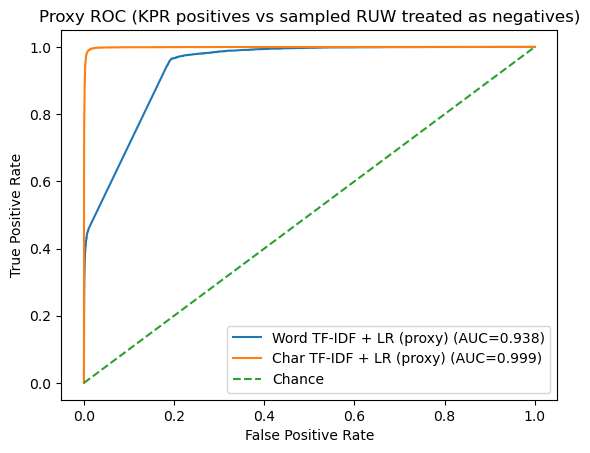

In [22]:
def plot_roc(y_true, y_score, label):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC={roc_auc:.3f})")
    return roc_auc
y = val_base["y"].astype(int).values
p_word = baseline.predict_proba(val_base["text_norm"])[:, 1]
p_char = baseline_char.predict_proba(val_base["text_norm"])[:, 1]

plt.figure()
plot_roc(y, p_word, "Word TF-IDF + LR (proxy)")
plot_roc(y, p_char, "Char TF-IDF + LR (proxy)")
plt.plot([0, 1], [0, 1], linestyle="--", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Proxy ROC (KPR positives vs sampled RUW treated as negatives)")
plt.legend()
plt.show()

In [23]:
# Compare baseline models on held-out KPR positives + reliable negatives (proxy)

# 1) held-out KPR recall
kpr_test_prob_base = baseline.predict_proba(kpr_test["text_norm"])[:,1]
kpr_test_pred_base = (kpr_test_prob_base >= 0.5).astype(int)
print("Baseline word: held-out KPR recall:", (kpr_test_pred_base == 1).mean())

kpr_test_prob_char = baseline_char.predict_proba(kpr_test["text_norm"])[:,1]
kpr_test_pred_char = (kpr_test_prob_char >= 0.5).astype(int)
print("Baseline char: held-out KPR recall:", (kpr_test_pred_char == 1).mean())

# 2) proxy FPR on reliable negatives
rn_test = reliable_neg.sample(n=min(len(reliable_neg), 10*len(kpr_test)), random_state=99)

rn_pred_base = (baseline.predict_proba(rn_test["text_norm"])[:,1] >= 0.5).astype(int)
print("Baseline word: proxy FPR on reliable neg:", (rn_pred_base == 1).mean())

rn_pred_char = (baseline_char.predict_proba(rn_test["text_norm"])[:,1] >= 0.5).astype(int)
print("Baseline char: proxy FPR on reliable neg:", (rn_pred_char == 1).mean())

Baseline word: held-out KPR recall: 0.9736658354114713
Baseline char: held-out KPR recall: 0.995211970074813
Baseline word: proxy FPR on reliable neg: 0.0
Baseline char: proxy FPR on reliable neg: 0.0007472371888150391


In [24]:
vec = pu_model.named_steps["tfidf"]
clf = pu_model.named_steps["logit"]

names = np.array(vec.get_feature_names_out())
coef = clf.coef_[0]

top_pos = names[np.argsort(coef)[-20:]][::-1]
top_neg = names[np.argsort(coef)[:20]]

print("Top positive features (KPR-like):", top_pos)
print("Top negative features (non-KPR-like):", top_neg)

Top positive features (KPR-like): ['我在' '分享丁丁的博文' '哈哈' '空气质量' '天气' '丁丁' '呵呵' '晚安' '赣州' '我在这里' '3级' '花心' '视频'
 '今日' '3级 空气质量' '起火原因正在调查' '多云' '睡觉' '勋章' '起火原因和过火面积正在调查']
Top negative features (non-KPR-like): ['沙姆雄狮_el的' '衝鋒号角的' '何天恩' '包容万物恒河水的' '俄罗斯' '孤烟暮蝉的' '俄乌局势最新进展' '乌克兰'
 '地球镜头a的' '台湾井事的' '俄罗斯联邦' '红袍萤火虫ix的' '军武季的' '央视新闻' '报道称' '看看新闻knews的'
 '今日俄罗斯rt的' 'cgtn记者团的' '海客新闻的' '普京']


In [25]:
kpr_test_prob = pu_model.predict_proba(kpr_test["text_norm"])[:,1]
kpr_test_pred = (kpr_test_prob >= 0.5).astype(int)

pos_recall = (kpr_test_pred == 1).mean()
print("Held-out KPR positive recall:", pos_recall)


Held-out KPR positive recall: 0.9989027431421447


In [50]:
rn_test = reliable_neg.sample(n=min(len(reliable_neg), 10*len(kpr_test)), random_state=99)
rn_prob = pu_model.predict_proba(rn_test["text_norm"])[:,1]
rn_pred = (rn_prob >= 0.5).astype(int)

fpr = (rn_pred == 1).mean()
print("Proxy FPR on reliable negatives:", fpr)

Proxy FPR on reliable negatives: 0.0021630550202540607


In [37]:
ruw_df["kpr_style_score"] = pu_model.predict_proba(ruw_df["text_norm"])[:,1]
ruw_df["kpr_style_score"].describe()

count    1.162170e+05
mean     5.786488e-01
std      4.146076e-01
min      3.524765e-07
25%      5.320418e-02
50%      8.212333e-01
75%      9.637042e-01
max      9.935656e-01
Name: kpr_style_score, dtype: float64

In [42]:
acct_stats = (
    ruw_df.groupby("user")["kpr_style_score"]
          .agg(mean_score="mean", median_score="median", n_posts="size")
          .sort_values(["mean_score", "n_posts"], ascending=[False, False])
)

top20 = acct_stats.head(20)
top20

,mean_score,median_score,n_posts
user,,,
捏张的娃娃,0.964456,0.963704,5
冰彬兵,0.963921,0.963704,8
军机不可泄露,0.963704,0.963704,2
句寻章,0.955523,0.967683,34
河北新闻哥,0.955268,0.963704,7
事发programme,0.952568,0.963704,7
张胜军,0.949309,0.963704,160
菊厂影业Fans,0.947036,0.963704,12
禾几Voix,0.942734,0.963704,135


In [47]:
# u = top20.index[0]
u = '漂亮国傻事'

user_posts = ruw_df.loc[ruw_df["user"] == u, ["tweetID", "date", "kpr_style_score", "text"]].copy()

print("User:", u, "| n_posts:", len(user_posts), "| mean_score:", user_posts["kpr_style_score"].mean())

# Lowest-scoring posts (most non-KPR-like)
user_posts.sort_values("kpr_style_score", ascending=True).head(10)

User: 漂亮国傻事 | n_posts: 377 | mean_score: 0.9280085434579174


,tweetID,date,kpr_style_score,text
97912,4740122295931091,Wed Feb 23 19:44:45 +0800 2022,0.000797,俄罗斯:堂下所跪何人，状告本官啊？
98105,4759680263390771,Mon Apr 18 19:01:08 +0800 2022,0.001236,我，乌克兰，欧洲太上皇，打钱。
97858,4740836313533191,Fri Feb 25 19:02:00 +0800 2022,0.001236,电影名字我都给你们想好了，就叫《乌克兰·最后之战》。
98062,4757870300103341,Wed Apr 13 19:08:59 +0800 2022,0.009176,"""#共青团# 共青团中央发文反对极端女权的这次事件闹到现在，可以说已经是搞的骑虎难下了。目前..."
97690,4746971250428819,Mon Mar 14 17:20:03 +0800 2022,0.013517,泽连斯基:已经快20天了，美援还没到怎么办？在线等，急!
98005,4716769421299323,Tue Dec 21 09:08:46 +0800 2021,0.059776,帝吧19号，德国新任国防部长兰布雷希特表示，如果俄罗斯“入侵”乌克兰，就要禁止普京去巴黎的香...
97915,4740048988146532,Wed Feb 23 14:53:27 +0800 2022,0.089086,"""#特朗普称普京的行动是天才之举# 特朗普接受采访说：“我昨天看电视，我说这真是天才之..."
98064,4757749555270811,Wed Apr 13 11:09:11 +0800 2022,0.091800,"""#共青团#共青团中央，还有北京晚报，昨天发了这两个微博之后，全部被冲疯了，其中团团的微博更..."
97725,4744684054515827,Tue Mar 08 09:51:33 +0800 2022,0.137040,#俄罗斯政府取消向不友好国家支付专利费#这招挺狠啊，昨天刚刚列的不友好国家地区名单，今天大招...
97701,4746528679266245,Sun Mar 13 12:01:26 +0800 2022,0.174459,波兰，一名49岁的男子以提供住所为由将一名19岁的乌克兰女性难民引诱至家中实施强奸，目前他已...


Posts per day for user: 漂亮国傻事


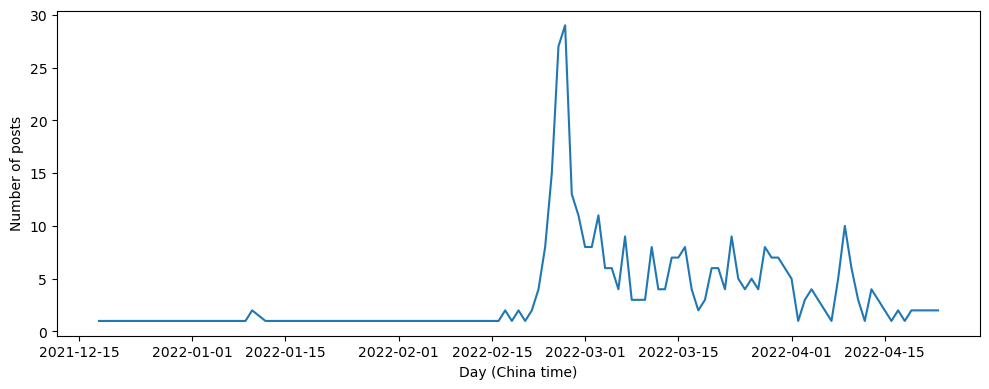

In [48]:
#Figure 1
tmp = ruw_df.loc[ruw_df["user"] == u, ["date_parsed"]].copy()

posts_per_day = (
    tmp.assign(day=tmp["date_parsed"].dt.tz_convert("Asia/Shanghai").dt.floor("D"))
       .groupby("day")
       .size()
       .sort_index()
)

print(f"Posts per day for user: {u}")
plt.figure(figsize=(10,4))
plt.plot(posts_per_day.index, posts_per_day.values)
plt.xlabel("Day (China time)")
plt.ylabel("Number of posts")
# plt.title(f"Posts per day for user: {u}")
plt.tight_layout()
plt.show()

In [41]:
bottom20 = acct_stats.sort_values(["mean_score", "n_posts"], ascending=[True, False]).head(20)
bottom20

,mean_score,median_score,n_posts
user,,,
看看新闻KNEWS,0.092575,0.005420,718
缘木球鱼,0.101948,0.010546,495
何天恩,0.119305,0.001160,2782
彼的宝在俄罗斯,0.131026,0.014232,687
CGTN记者团,0.138664,0.005731,696
海客新闻,0.154415,0.067721,528
青蜂侠Bee,0.173464,0.042282,215
衝鋒号角,0.203452,0.000726,3471
辽宁大鹏888,0.209182,0.001060,2120


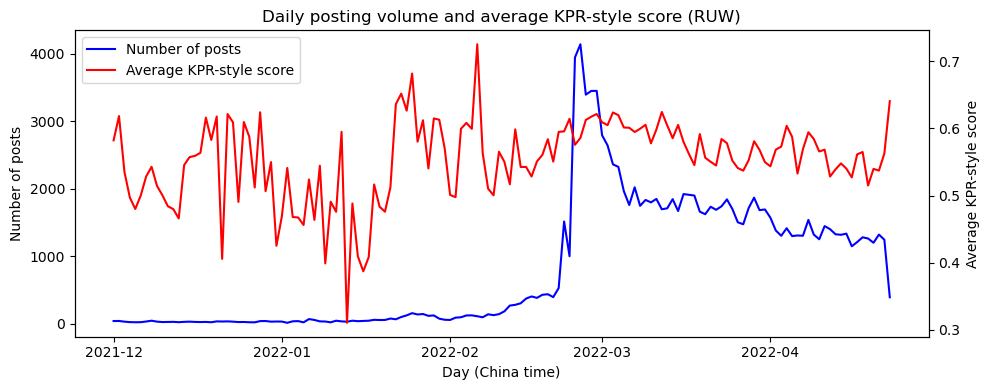

In [64]:
tmp = ruw_df[["date_parsed", "kpr_style_score"]].copy()
tmp["day"] = tmp["date_parsed"].dt.tz_convert("Asia/Shanghai").dt.floor("D")

daily = tmp.groupby("day").agg(
    n_posts=("kpr_style_score", "size"),
    avg_kpr=("kpr_style_score", "mean")
).sort_index()

# daily = daily[daily["n_posts"] >= 100].copy()
daily = daily[:-1]

fig, ax1 = plt.subplots(figsize=(10,4))

# left axis: number of posts per day
ax1.plot(daily.index, daily["n_posts"],color='blue',label="Number of posts")
ax1.set_xlabel("Day (China time)")
ax1.set_ylabel("Number of posts")

# right axis: average KPR-style score per day
ax2 = ax1.twinx()
ax2.plot(daily.index, daily["avg_kpr"],color='red',label="Average KPR-style score")
ax2.set_ylabel("Average KPR-style score")

plt.title("Daily posting volume and average KPR-style score (RUW)")
plt.tight_layout()

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles = handles1 + handles2
labels = labels1 + labels2

# Create a single legend on ax1 with the combined data
ax1.legend(handles, labels, loc='upper left')

plt.savefig('VolumeAndKpr.svg')
plt.show()

In [58]:
peak_day = daily["n_posts"].idxmax()
peak_n = int(daily.loc[peak_day, "n_posts"])
peak_avg = float(daily.loc[peak_day, "avg_kpr"])
print("Peak day (China time):", peak_day.date(), "| posts:", peak_n, "| avg KPR-style:", round(peak_avg, 3))

Peak day (China time): 2022-02-25 | posts: 4139 | avg KPR-style: 0.586


In [ ]:
ruw_df.sort_values("kpr_style_score", ascending=False).head(20)[["kpr_style_score","text"]]

In [ ]:
ruw_df.sort_values("kpr_style_score", ascending=False).tail(20)[["kpr_style_score","text"]]

In [ ]:
#Full texts --- Table 2
ruw_ids = [37438, 37563, 37276, 36968, 68645, 79792, 65204, 84961]  # add any others you want

for i in ruw_ids:
    print("\n" + "="*90)
    print(f"RUW row ID: {i} | score: {ruw_df.loc[i,'kpr_style_score']:.6e}")
    print(ruw_df.loc[i, "text"])  # full string